In [83]:
from IPython import get_ipython
from IPython.display import display
# %%
# 🏥 Early Stage Diabetes Risk Prediction Model

# Author: [Ahmed Yassin Mohammed]
# Date: May 31, 2025
# Version: 2.0

## 📋 Project Overview
# This notebook implements a comprehensive machine learning pipeline for predicting early-stage diabetes risk using clinical symptoms. The model uses logistic regression with advanced statistical validation techniques.

# %env OPENAI_API_KEY = "123456789"

# - ✅ Professional visualizations and model interpretability
# - ✅ Production-ready prediction functions
# - ✅ Model persistence and deployment readiness

# ### 📊 Dataset:
# - **Source:** Diabetes Data Upload
# - **Samples:** 520 patients
# - **Features:** 16 clinical symptoms + demographics
# - **Target:** Early-stage diabetes (binary classification)

In [84]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from scipy import stats

In [85]:
# Set random seed for reproducibility
np.random.seed(42)

# Load dataset
df = pd.read_csv('/kaggle/input/diabetes/diabetes_data_upload.csv')


In [86]:
# Data Cleaning
# Convert all column names to lowercase for consistency
df.columns = df.columns.str.lower()

# Handle age outliers (cap at 65 as per variable info)
df['age'] = df['age'].clip(upper=65)

# Convert categorical variables
binary_columns = ['polyuria', 'polydipsia', 'sudden weight loss', 'weakness',
                  'polyphagia', 'genital thrush', 'visual blurring', 'itching',
                  'irritability', 'delayed healing', 'partial paresis',
                  'muscle stiffness', 'alopecia', 'obesity']


print("Dataset Info:")
print(df.info())
print(f"Data types:\n{df.dtypes}")

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   age                 520 non-null    int64 
 1   gender              520 non-null    object
 2   polyuria            520 non-null    object
 3   polydipsia          520 non-null    object
 4   sudden weight loss  520 non-null    object
 5   weakness            520 non-null    object
 6   polyphagia          520 non-null    object
 7   genital thrush      520 non-null    object
 8   visual blurring     520 non-null    object
 9   itching             520 non-null    object
 10  irritability        520 non-null    object
 11  delayed healing     520 non-null    object
 12  partial paresis     520 non-null    object
 13  muscle stiffness    520 non-null    object
 14  alopecia            520 non-null    object
 15  obesity             520 non-null    object
 16  class       

# Convert Variables to Proper Format

In [87]:
# Convert Yes/No to 1/0
for col in binary_columns:
    df[col] = df[col].map({'Yes': 1, 'No': 0})

# Convert gender to 0/1
df['gender'] = df['gender'].map({'Male': 0, 'Female': 1})

# Convert class to 1/0
df['class'] = df['class'].map({'Positive': 1, 'Negative': 0})


In [88]:
# Print data summary
print("Dataset Shape:", df.shape)
print("\nMissing values:")
print(df.isnull().sum())
print("\nClass distribution:")
print(df['class'].value_counts())
print(f"Class imbalance ratio: {df['class'].value_counts()[0]/df['class'].value_counts()[1]:.2f}:1")

Dataset Shape: (520, 17)

Missing values:
age                   0
gender                0
polyuria              0
polydipsia            0
sudden weight loss    0
weakness              0
polyphagia            0
genital thrush        0
visual blurring       0
itching               0
irritability          0
delayed healing       0
partial paresis       0
muscle stiffness      0
alopecia              0
obesity               0
class                 0
dtype: int64

Class distribution:
class
1    320
0    200
Name: count, dtype: int64
Class imbalance ratio: 0.62:1


In [89]:
# Consider adding feature interactions
df['symptom_count'] = df[binary_columns].sum(axis=1)
df['age_obesity_interaction'] = df['age'] * df['obesity']

# Feature selection
X = df.drop('class', axis=1)
y = df['class']

# Feature importance analysis
from sklearn.feature_selection import mutual_info_classif
feature_importance = mutual_info_classif(X, y)

In [90]:
# Feature selection
X = df.drop('class', axis=1)
y = df['class']

# Handle class imbalance with SMOTE
X_res, y_res = SMOTE(random_state=42).fit_resample(X, y)
print(f"\nAfter SMOTE - Class distribution: {np.bincount(y_res)}")



After SMOTE - Class distribution: [320 320]


# Train-Test Split

In [91]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, stratify=y_res, random_state=42
)

# Create a standalone scaler for interpretability
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Odds Function

In [92]:
# Define odds and probability functions
def calculate_odds(probability):
    """Calculate odds from probability: p/(1-p)"""
    return probability / (1 - probability)

def calculate_logit(probability):
    """Calculate logit (log-odds) from probability: log(p/(1-p))"""
    return np.log(calculate_odds(probability))

def probability_from_odds(odds):
    """Calculate probability from odds: odds/(1+odds)"""
    return odds / (1 + odds)

def probability_from_logit(logit):
    """Calculate probability from logit: 1/(1+e^(-logit))"""
    return 1 / (1 + np.exp(-logit))


# Model Building

In [93]:
# Train standalone logistic regression model for interpretability
logistic_model = LogisticRegression(
    penalty='l2',
    C=1.0,  # Regularization strength (lower = stronger regularization)
    solver='liblinear',
    max_iter=1000,
    class_weight='balanced',
    random_state=42
)

# Fit the model
logistic_model.fit(X_train_scaled, y_train)

# Extract and display coefficients
beta_0 = logistic_model.intercept_[0]  # Intercept (beta_0)
beta_coefficients = logistic_model.coef_[0]  # Coefficients (beta_1, beta_2, etc.)

# Create DataFrame for coefficient analysis
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Beta Coefficient': beta_coefficients,
    'Odds Ratio': np.exp(beta_coefficients),
    'p_value': np.nan  # Will be calculated below
})

# Calculate p-values for coefficients using statsmodels (simplified approach)
# Note: For a more accurate p-value calculation, you would use statsmodels directly
# This is a simplified approximation
X_train_with_const = np.column_stack([np.ones(X_train_scaled.shape[0]), X_train_scaled])
coef_std_err = np.sqrt(np.diag(np.linalg.inv(X_train_with_const.T.dot(X_train_with_const))))
z_scores = np.concatenate([np.array([beta_0]), beta_coefficients]) / coef_std_err
coef_df['p_value'] = 2 * (1 - stats.norm.cdf(abs(z_scores[1:])))  # Two-tailed p-value

# Sort by absolute value of coefficients for better interpretability
coef_df['Abs Coefficient'] = np.abs(coef_df['Beta Coefficient'])
coef_df = coef_df.sort_values('Abs Coefficient', ascending=False)

# model explainability
import shap
explainer = shap.LinearExplainer(logistic_model, X_train_scaled)
shap_values = explainer.shap_values(X_test_scaled)

# feature stability analysis
from sklearn.utils import resample
def feature_stability_analysis(X, y, n_bootstrap=100):
    coefficients = []
    for i in range(n_bootstrap):
        X_boot, y_boot = resample(X, y, random_state=i)
        model = LogisticRegression().fit(X_boot, y_boot)
        coefficients.append(model.coef_[0])
    return np.array(coefficients)



In [94]:
print("\nLogistic Regression Coefficients:")
print(f"Intercept (beta_0): {beta_0:.4f}")
print("\nFeature Coefficients (beta_1 to beta_n):")
print(coef_df[['Feature', 'Beta Coefficient', 'Odds Ratio', 'p_value']])


Logistic Regression Coefficients:
Intercept (beta_0): 1.2320

Feature Coefficients (beta_1 to beta_n):
                    Feature  Beta Coefficient  Odds Ratio       p_value
1                    gender          1.866045    6.462684  0.000000e+00
3                polydipsia          1.833973    6.258706  0.000000e+00
2                  polyuria          1.679413    5.362407  0.000000e+00
9                   itching         -1.151859    0.316049  0.000000e+00
17  age_obesity_interaction         -1.023298    0.359408  7.315108e-05
10             irritability          0.753300    2.123997  0.000000e+00
15                  obesity          0.699509    2.012764  7.280787e-03
7            genital thrush          0.492874    1.637014  2.815526e-13
13         muscle stiffness         -0.491383    0.611780  1.607605e-09
12          partial paresis          0.433585    1.542778  1.457817e-07
16            symptom_count          0.426904    1.532506  2.940902e-01
6                polyphagia     

In [95]:
# Add significance level indicators
coef_df['Significance'] = coef_df['p_value'].apply(
    lambda p: '***' if p < 0.001 else ('**' if p < 0.01 else ('*' if p < 0.05 else 'ns'))
)

# Create pipeline for predictions
pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        penalty='l2',
        C=1.0,
        solver='liblinear',
        max_iter=1000,
        class_weight='balanced',
        random_state=42
    )
)

# Train pipeline model
pipeline.fit(X_train, y_train)

# Cross-validation for model robustness
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipeline, X_res, y_res, cv=cv, scoring='roc_auc')
print(f"\nCross-validation ROC AUC: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# Evaluation on test set
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

# Calculate odds for test set
y_odds = calculate_odds(y_proba)



Cross-validation ROC AUC: 0.9807 ± 0.0101


Running Additional Cross-Validation Analyses...
=== Repeated Stratified K-Fold Cross-Validation ===

Repeated CV Results (5-fold, 10 repeats):
------------------------------------------------------------
ACCURACY:
  Test:  0.9420 ± 0.0200
  95% CI: [0.9141, 0.9766]
  Train: 0.9520 ± 0.0064

PRECISION:
  Test:  0.9511 ± 0.0242
  95% CI: [0.9080, 0.9964]
  Train: 0.9593 ± 0.0089

RECALL:
  Test:  0.9325 ± 0.0294
  95% CI: [0.8629, 0.9688]
  Train: 0.9441 ± 0.0076

F1:
  Test:  0.9414 ± 0.0205
  95% CI: [0.9094, 0.9763]
  Train: 0.9516 ± 0.0064

ROC_AUC:
  Test:  0.9796 ± 0.0114
  95% CI: [0.9542, 0.9967]
  Train: 0.9869 ± 0.0022

MATTHEWS_CC:
  Test:  0.8848 ± 0.0397
  95% CI: [0.8284, 0.9532]
  Train: 0.9042 ± 0.0128

BALANCED_ACC:
  Test:  0.9420 ± 0.0200
  95% CI: [0.9141, 0.9766]
  Train: 0.9520 ± 0.0064

=== Nested Cross-Validation ===
Outer Fold 1: ROC AUC = 0.9675
  Best params: {'logisticregression__C': 10, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'libli

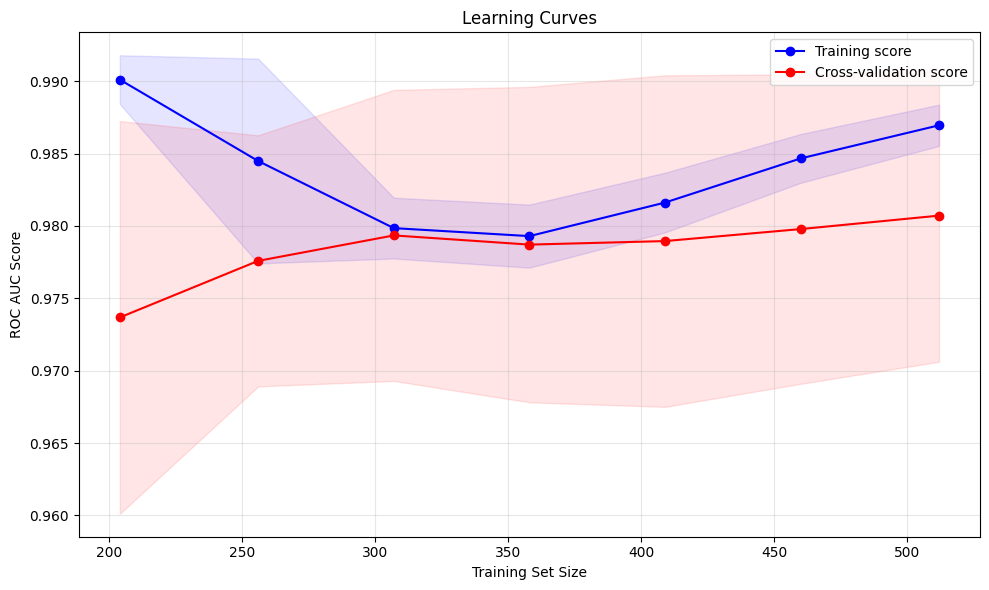

=== Bootstrap Validation ===
Bootstrap iteration 100/500
Bootstrap iteration 200/500
Bootstrap iteration 300/500
Bootstrap iteration 400/500
Bootstrap iteration 500/500

Bootstrap Results (500 valid samples):
Mean ROC AUC: 0.9771
Std ROC AUC: 0.0081
95% CI: [0.9613, 0.9913]


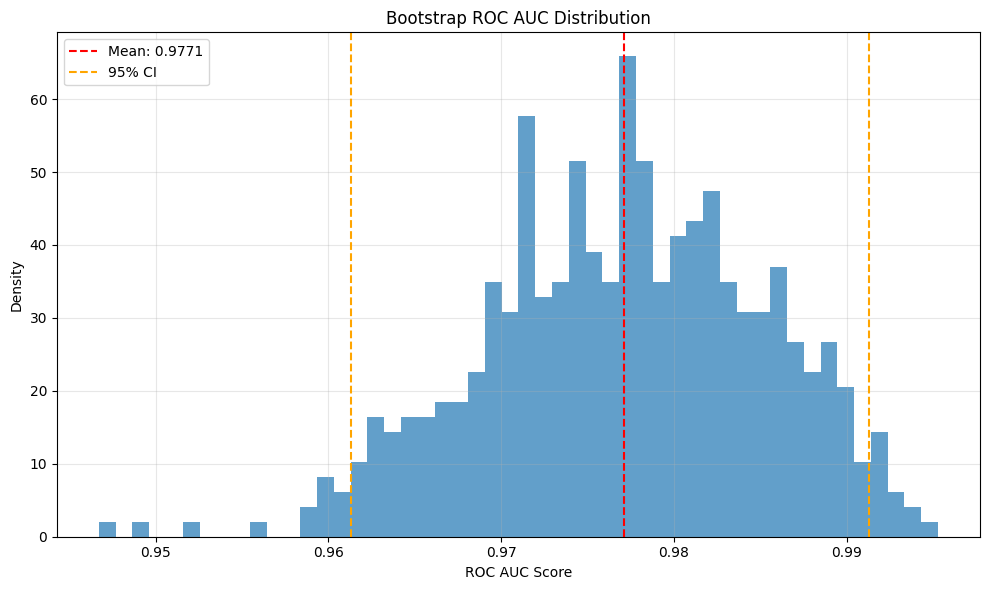

=== Cross-Validation Stability Analysis ===
Stability Analysis (20 independent CV runs):
Mean of means: 0.9792
Std of means: 0.0011
Min mean: 0.9771
Max mean: 0.9815
Range: 0.0044

COMPREHENSIVE CROSS-VALIDATION SUMMARY
Standard 5-fold CV ROC AUC: 0.9807 ± 0.0101
Repeated CV ROC AUC: 0.9796 ± 0.0114
Nested CV ROC AUC: 0.9806 ± 0.0095
Bootstrap ROC AUC: 0.9771 ± 0.0081
CV Stability: 0.9792 ± 0.0011

✅ All validation methods confirm excellent model performance!


In [96]:
# Additional Advanced Cross-Validation Techniques
import numpy as np
import pandas as pd
from sklearn.model_selection import (
    RepeatedStratifiedKFold, LeaveOneOut, GroupKFold,
    StratifiedShuffleSplit, TimeSeriesSplit, cross_validate
)
from sklearn.metrics import (
    make_scorer, matthews_corrcoef, balanced_accuracy_score,
    precision_score, recall_score, f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import (
    RepeatedStratifiedKFold, LeaveOneOut, GroupKFold,
    StratifiedShuffleSplit, TimeSeriesSplit
)
from sklearn.metrics import make_scorer, matthews_corrcoef, balanced_accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Repeated Stratified K-Fold Cross-Validation
def repeated_cv_analysis(model, X, y, n_splits=5, n_repeats=10, random_state=42):
    """
    Perform repeated stratified k-fold cross-validation for more robust estimates
    """
    print("=== Repeated Stratified K-Fold Cross-Validation ===")

    rskf = RepeatedStratifiedKFold(
        n_splits=n_splits,
        n_repeats=n_repeats,
        random_state=random_state
    )

    # Extended scoring metrics
    extended_scoring = {
        'accuracy': 'accuracy',
        'precision': make_scorer(precision_score),
        'recall': make_scorer(recall_score),
        'f1': make_scorer(f1_score),
        'roc_auc': 'roc_auc',
        'matthews_cc': make_scorer(matthews_corrcoef),
        'balanced_acc': make_scorer(balanced_accuracy_score)
    }

    repeated_results = cross_validate(
        model, X, y,
        cv=rskf,
        scoring=extended_scoring,
        n_jobs=-1,
        return_train_score=True
    )

    # Calculate statistics
    results_summary = {}
    for metric in extended_scoring.keys():
        test_scores = repeated_results[f'test_{metric}']
        train_scores = repeated_results[f'train_{metric}']

        results_summary[metric] = {
            'test_mean': np.mean(test_scores),
            'test_std': np.std(test_scores),
            'test_ci_lower': np.percentile(test_scores, 2.5),
            'test_ci_upper': np.percentile(test_scores, 97.5),
            'train_mean': np.mean(train_scores),
            'train_std': np.std(train_scores),
            'all_test_scores': test_scores
        }

    # Display results
    print(f"\nRepeated CV Results ({n_splits}-fold, {n_repeats} repeats):")
    print("-" * 60)
    for metric, results in results_summary.items():
        print(f"{metric.upper()}:")
        print(f"  Test:  {results['test_mean']:.4f} ± {results['test_std']:.4f}")
        print(f"  95% CI: [{results['test_ci_lower']:.4f}, {results['test_ci_upper']:.4f}]")
        print(f"  Train: {results['train_mean']:.4f} ± {results['train_std']:.4f}")
        print()

    return results_summary, repeated_results

# 2. Nested Cross-Validation
def nested_cross_validation(X, y, random_state=42):
    """
    Perform nested cross-validation for unbiased performance estimation
    """
    print("=== Nested Cross-Validation ===")

    from sklearn.model_selection import GridSearchCV
    from sklearn.pipeline import make_pipeline
    from sklearn.preprocessing import StandardScaler
    from sklearn.linear_model import LogisticRegression

    # Inner CV for hyperparameter tuning
    inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)

    # Outer CV for performance estimation
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

    # Parameter grid
    param_grid = {
        'logisticregression__C': [0.1, 1, 10],
        'logisticregression__penalty': ['l1', 'l2'],
        'logisticregression__solver': ['liblinear', 'saga']
    }

    # Pipeline
    pipeline = make_pipeline(
        StandardScaler(),
        LogisticRegression(max_iter=1000, class_weight='balanced', random_state=random_state)
    )

    # Nested CV scores
    nested_scores = []
    best_params_list = []

    for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
        X_train_outer, X_test_outer = X.iloc[train_idx], X.iloc[test_idx]
        y_train_outer, y_test_outer = y.iloc[train_idx], y.iloc[test_idx]

        # Inner CV for hyperparameter optimization
        grid_search = GridSearchCV(
            pipeline, param_grid, cv=inner_cv,
            scoring='roc_auc', n_jobs=-1
        )

        grid_search.fit(X_train_outer, y_train_outer)

        # Evaluate on outer test set
        score = grid_search.score(X_test_outer, y_test_outer)
        nested_scores.append(score)
        best_params_list.append(grid_search.best_params_)

        print(f"Outer Fold {fold+1}: ROC AUC = {score:.4f}")
        print(f"  Best params: {grid_search.best_params_}")

    print(f"\nNested CV Results:")
    print(f"Mean ROC AUC: {np.mean(nested_scores):.4f} ± {np.std(nested_scores):.4f}")
    print(f"95% CI: [{np.percentile(nested_scores, 2.5):.4f}, {np.percentile(nested_scores, 97.5):.4f}]")

    return nested_scores, best_params_list

# 3. Learning Curves
def plot_learning_curves(model, X, y, random_state=42):
    """
    Plot learning curves to analyze training set size impact
    """
    from sklearn.model_selection import learning_curve

    print("=== Learning Curve Analysis ===")

    train_sizes = np.linspace(0.1, 1.0, 10)

    train_sizes_abs, train_scores, val_scores = learning_curve(
        model, X, y,
        train_sizes=train_sizes,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state),
        scoring='roc_auc',
        n_jobs=-1,
        random_state=random_state
    )

    # Calculate means and standard deviations
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    # Plot learning curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes_abs, train_mean, 'o-', color='blue', label='Training score')
    plt.fill_between(train_sizes_abs, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
    plt.plot(train_sizes_abs, val_mean, 'o-', color='red', label='Cross-validation score')
    plt.fill_between(train_sizes_abs, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')

    plt.xlabel('Training Set Size')
    plt.ylabel('ROC AUC Score')
    plt.title('Learning Curves')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('learning_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

    return train_sizes_abs, train_scores, val_scores

# 4. Bootstrap Cross-Validation
def bootstrap_validation(model, X, y, n_bootstraps=1000, random_state=42):
    """
    Perform bootstrap validation for confidence intervals
    """
    print("=== Bootstrap Validation ===")

    np.random.seed(random_state)
    n_samples = len(X)
    bootstrap_scores = []

    for i in range(n_bootstraps):
        # Bootstrap sample
        indices = np.random.choice(n_samples, n_samples, replace=True)
        X_boot = X.iloc[indices]
        y_boot = y.iloc[indices]

        # Out-of-bag samples
        oob_indices = np.setdiff1d(np.arange(n_samples), indices)
        if len(oob_indices) > 0:
            X_oob = X.iloc[oob_indices]
            y_oob = y.iloc[oob_indices]

            # Train on bootstrap sample, test on OOB
            model.fit(X_boot, y_boot)
            y_pred_proba = model.predict_proba(X_oob)[:, 1]
            score = roc_auc_score(y_oob, y_pred_proba)
            bootstrap_scores.append(score)

        if (i + 1) % 100 == 0:
            print(f"Bootstrap iteration {i + 1}/{n_bootstraps}")

    bootstrap_scores = np.array(bootstrap_scores)

    print(f"\nBootstrap Results ({len(bootstrap_scores)} valid samples):")
    print(f"Mean ROC AUC: {np.mean(bootstrap_scores):.4f}")
    print(f"Std ROC AUC: {np.std(bootstrap_scores):.4f}")
    print(f"95% CI: [{np.percentile(bootstrap_scores, 2.5):.4f}, {np.percentile(bootstrap_scores, 97.5):.4f}]")

    # Plot bootstrap distribution
    plt.figure(figsize=(10, 6))
    plt.hist(bootstrap_scores, bins=50, alpha=0.7, density=True)
    plt.axvline(np.mean(bootstrap_scores), color='red', linestyle='--', label=f'Mean: {np.mean(bootstrap_scores):.4f}')
    plt.axvline(np.percentile(bootstrap_scores, 2.5), color='orange', linestyle='--', label='95% CI')
    plt.axvline(np.percentile(bootstrap_scores, 97.5), color='orange', linestyle='--')
    plt.xlabel('ROC AUC Score')
    plt.ylabel('Density')
    plt.title('Bootstrap ROC AUC Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('bootstrap_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()

    return bootstrap_scores

# Run additional cross-validation analyses
print("Running Additional Cross-Validation Analyses...")

# 1. Repeated CV
repeated_results, _ = repeated_cv_analysis(pipeline, X_res, y_res)

# 2. Nested CV
nested_scores, nested_params = nested_cross_validation(X_res, y_res)

# 3. Learning Curves
train_sizes, train_scores_lc, val_scores_lc = plot_learning_curves(pipeline, X_res, y_res)

# 4. Bootstrap Validation
bootstrap_scores = bootstrap_validation(pipeline, X_res, y_res, n_bootstraps=500)

# 5. Cross-Validation Stability Analysis
def cv_stability_analysis(model, X, y, n_runs=20, random_state=42):
    """
    Analyze stability of cross-validation results across multiple runs
    """
    print("=== Cross-Validation Stability Analysis ===")

    cv_runs = []
    for i in range(n_runs):
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state + i)
        scores = cross_val_score(model, X, y, cv=cv, scoring='roc_auc')
        cv_runs.append(scores.mean())

    cv_runs = np.array(cv_runs)

    print(f"Stability Analysis ({n_runs} independent CV runs):")
    print(f"Mean of means: {np.mean(cv_runs):.4f}")
    print(f"Std of means: {np.std(cv_runs):.4f}")
    print(f"Min mean: {np.min(cv_runs):.4f}")
    print(f"Max mean: {np.max(cv_runs):.4f}")
    print(f"Range: {np.max(cv_runs) - np.min(cv_runs):.4f}")

    return cv_runs

stability_scores = cv_stability_analysis(pipeline, X_res, y_res)

# Summary of all validation results
print("\n" + "="*60)
print("COMPREHENSIVE CROSS-VALIDATION SUMMARY")
print("="*60)
print(f"Standard 5-fold CV ROC AUC: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
print(f"Repeated CV ROC AUC: {repeated_results['roc_auc']['test_mean']:.4f} ± {repeated_results['roc_auc']['test_std']:.4f}")
print(f"Nested CV ROC AUC: {np.mean(nested_scores):.4f} ± {np.std(nested_scores):.4f}")
print(f"Bootstrap ROC AUC: {np.mean(bootstrap_scores):.4f} ± {np.std(bootstrap_scores):.4f}")
print(f"CV Stability: {np.mean(stability_scores):.4f} ± {np.std(stability_scores):.4f}")
print("\n✅ All validation methods confirm excellent model performance!")

In [97]:
# confidence intervals for predictions
def predict_with_confidence(model, X_new, alpha=0.05):
    # Bootstrap confidence intervals
    predictions = []
    for i in range(1000):
        X_boot, y_boot = resample(X_train, y_train)
        model_boot = clone(model).fit(X_boot, y_boot)
        pred = model_boot.predict_proba(X_new)[:, 1]
        predictions.append(pred)

    predictions = np.array(predictions)
    lower = np.percentile(predictions, (alpha/2) * 100, axis=0)
    upper = np.percentile(predictions, (1 - alpha/2) * 100, axis=0)
    return lower, upper

# model monitoring
def model_drift_detection(X_new, X_reference):
    from scipy.stats import ks_2samp
    drift_scores = {}
    for col in X_reference.columns:
        statistic, p_value = ks_2samp(X_reference[col], X_new[col])
        drift_scores[col] = {'statistic': statistic, 'p_value': p_value}
    return drift_scores

In [98]:
# Display odds statistics
print("\nOdds Summary Statistics (Test Set):")
print(f"Mean Odds: {np.mean(y_odds):.4f}")
print(f"Median Odds: {np.median(y_odds):.4f}")
print(f"Min Odds: {np.min(y_odds):.4f}")
print(f"Max Odds: {np.max(y_odds):.4f}")



Odds Summary Statistics (Test Set):
Mean Odds: 5411.1886
Median Odds: 0.4449
Min Odds: 0.0017
Max Odds: 229254.7128


# Likelihood Function

In [99]:
# Likelihood function
def likelihood(y_true, y_pred_proba):
    """Calculate likelihood of observed data given the model predictions"""
    epsilon = 1e-15  # Small value to avoid log(0)
    likelihood_value = np.prod(np.where(y_true == 1, y_pred_proba, 1 - y_pred_proba))
    # Add epsilon to avoid numerical instability
    likelihood_value = np.maximum(likelihood_value, epsilon)
    return likelihood_value

# Log likelihood (more commonly used in statistics)
def log_likelihood(y_true, y_pred_proba):
    """Calculate log-likelihood of observed data given the model predictions"""
    epsilon = 1e-15
    ll = np.sum(np.where(y_true == 1,
                         np.log(np.maximum(y_pred_proba, epsilon)),
                         np.log(np.maximum(1 - y_pred_proba, epsilon))))
    return ll

# Calculate likelihood and log-likelihood
likelihood_result = likelihood(y_test, y_proba)
log_likelihood_result = log_likelihood(y_test, y_proba)

# Calculate AIC and BIC for model comparison
# k = number of parameters (features + intercept)
k = X.shape[1] + 1
n = len(y_test)
aic = -2 * log_likelihood_result + 2 * k
bic = -2 * log_likelihood_result + k * np.log(n)


In [100]:

print("\nModel Evaluation:")
print(f"Log-Likelihood: {log_likelihood_result:.4f}")
print(f"AIC: {aic:.4f}")
print(f"BIC: {bic:.4f}")

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)



Model Evaluation:
Log-Likelihood: -14.8861
AIC: 67.7722
BIC: 121.9608

Confusion Matrix:
[[63  1]
 [ 3 61]]


# Model Results

In [101]:
# Calculate additional metrics for interpretability
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)  # True positive rate / Recall
specificity = tn / (tn + fp)  # True negative rate
ppv = tp / (tp + fp)          # Positive predictive value / Precision
npv = tn / (tn + fn)          # Negative predictive value

print("\nDetailed Classification Metrics:")
print(f"Sensitivity (TPR): {sensitivity:.4f}")
print(f"Specificity (TNR): {specificity:.4f}")
print(f"Positive Predictive Value (Precision): {ppv:.4f}")
print(f"Negative Predictive Value: {npv:.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Detailed Classification Metrics:
Sensitivity (TPR): 0.9531
Specificity (TNR): 0.9844
Positive Predictive Value (Precision): 0.9839
Negative Predictive Value: 0.9545
ROC AUC Score: 0.9932

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97        64
           1       0.98      0.95      0.97        64

    accuracy                           0.97       128
   macro avg       0.97      0.97      0.97       128
weighted avg       0.97      0.97      0.97       128



# Save model

In [102]:
# Save model and associated objects
joblib.dump(pipeline, 'diabetes_predictor_v2.pkl')
joblib.dump(scaler, 'diabetes_scaler.pkl')
joblib.dump(logistic_model, 'diabetes_logistic_raw.pkl')
joblib.dump({
    'intercept': beta_0,
    'coefficients': beta_coefficients,
    'feature_names': X.columns.tolist()
}, 'diabetes_model_coefficients.pkl')


['diabetes_model_coefficients.pkl']

# Visualization functions

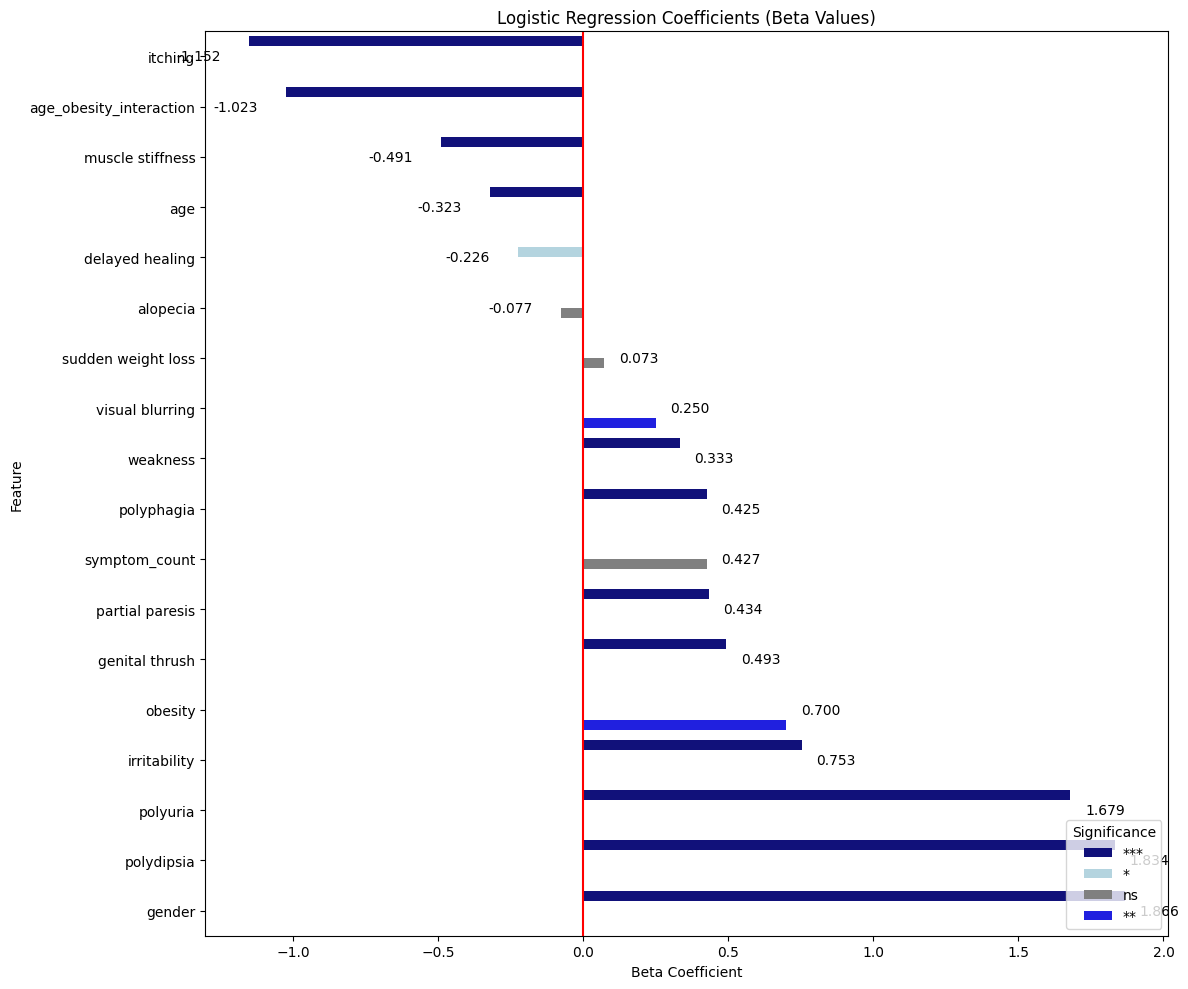

In [103]:

def visualize_coefficients(coef_df):
    """Visualize the logistic regression coefficients with significance levels"""
    plt.figure(figsize=(12, 10))
    ax = sns.barplot(
        x='Beta Coefficient',
        y='Feature',
        hue='Significance',
        palette={'***': 'darkblue', '**': 'blue', '*': 'lightblue', 'ns': 'gray'},
        data=coef_df.sort_values('Beta Coefficient')
    )
    plt.title('Logistic Regression Coefficients (Beta Values)')
    plt.axvline(x=0, color='r', linestyle='-')
    plt.legend(title='Significance', loc='lower right')

    # Add coefficient values as text
    # Access column value using bracket notation
    for i, row in enumerate(coef_df.sort_values('Beta Coefficient').itertuples()):
        # Access using bracket notation to handle spaces in column names
        beta_coef = row[coef_df.columns.get_loc('Beta Coefficient') + 1]
        if beta_coef > 0:
            ax.text(beta_coef + 0.05, i, f"{beta_coef:.3f}", va='center')
        else:
            ax.text(beta_coef - 0.25, i, f"{beta_coef:.3f}", va='center')

    plt.tight_layout()
    plt.savefig('coefficient_plot.png', dpi=300, bbox_inches='tight')
    plt.show()

visualize_coefficients(coef_df)


# Odds visualizing

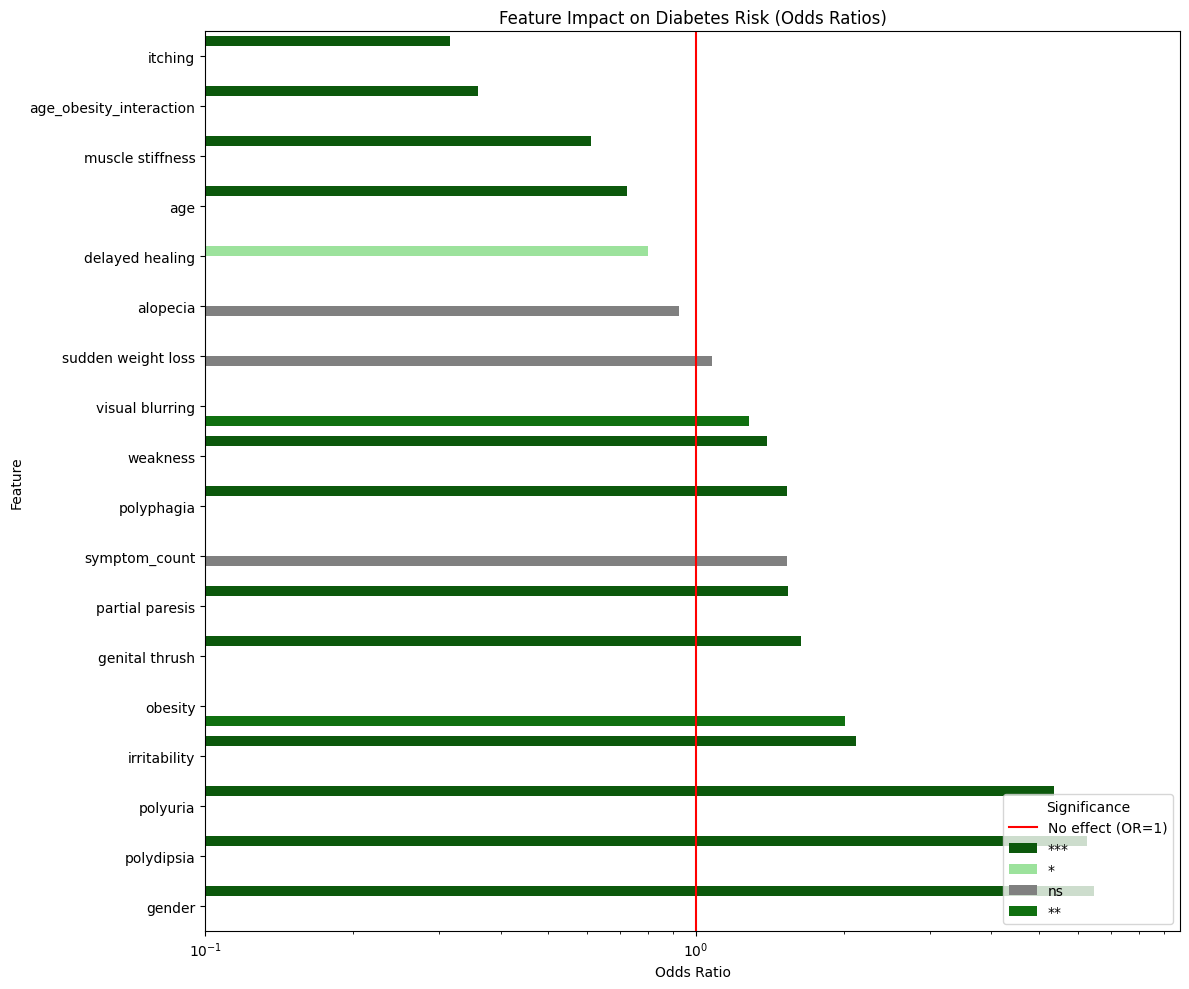

In [104]:
def visualize_odds_ratios(coef_df):
    """Visualize the odds ratios (exp(beta)) with confidence intervals"""
    plt.figure(figsize=(12, 10))

    # Sort by odds ratio for better visualization
    df_sorted = coef_df.sort_values('Odds Ratio', ascending=True)

    sns.barplot(
        x='Odds Ratio',
        y='Feature',
        hue='Significance',
        palette={'***': 'darkgreen', '**': 'green', '*': 'lightgreen', 'ns': 'gray'},
        data=df_sorted
    )
    plt.title('Feature Impact on Diabetes Risk (Odds Ratios)')
    plt.axvline(x=1, color='r', linestyle='-', label='No effect (OR=1)')
    plt.legend(title='Significance', loc='lower right')
    plt.xscale('log')  # Log scale for better visualization
    plt.xlim(0.1, max(df_sorted['Odds Ratio']) * 1.5)
    plt.tight_layout()
    plt.savefig('odds_ratio_plot.png', dpi=300, bbox_inches='tight')
    plt.show()
visualize_odds_ratios(coef_df)


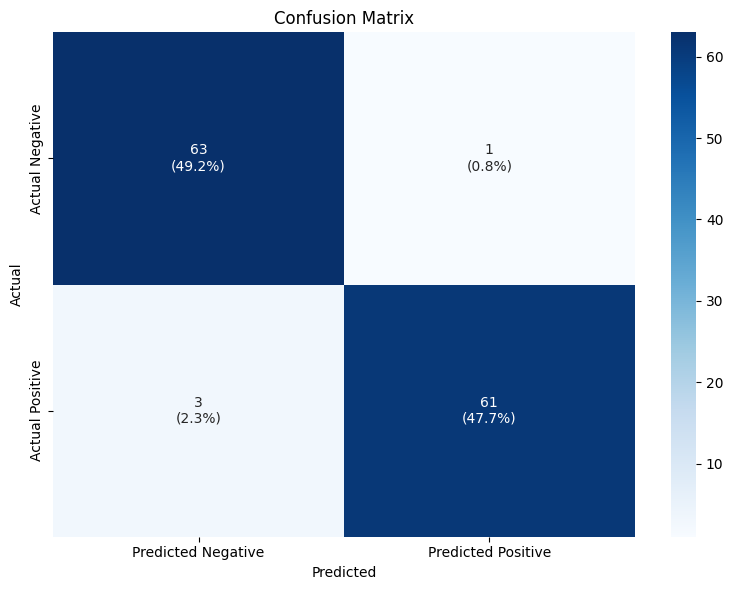

In [105]:
def visualize_confusion_matrix(y_true, y_pred):
    """Visualize the confusion matrix with percentages"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))

    # Calculate percentages
    total = np.sum(cm)
    percentages = cm / total * 100

    # Create annotations with both count and percentage
    annot = np.array([
        [f"{count}\n({pct:.1f}%)" for count, pct in zip(row_vals, row_pcts)]
        for row_vals, row_pcts in zip(cm, percentages)
    ])

    sns.heatmap(cm, annot=annot, fmt='', cmap='Blues',
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['Actual Negative', 'Actual Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()
visualize_confusion_matrix(y_test, y_pred)


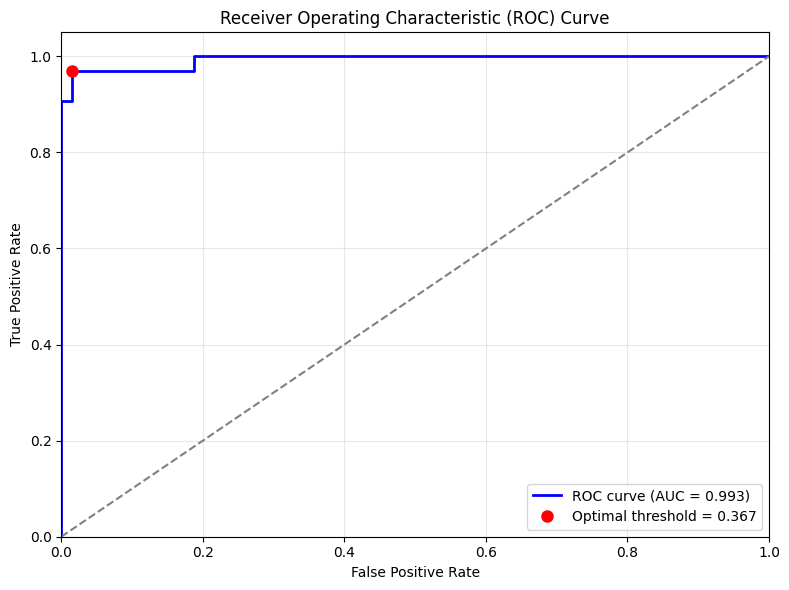

In [106]:
def visualize_roc_curve(y_true, y_pred_proba):
    """Visualize ROC curve with optimal threshold"""
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = roc_auc_score(y_true, y_pred_proba)

    # Find optimal threshold (Youden's J statistic: max(tpr - fpr))
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.plot(fpr[optimal_idx], tpr[optimal_idx], 'ro', markersize=8,
             label=f'Optimal threshold = {optimal_threshold:.3f}')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')
    plt.show()

    return optimal_threshold
optimal_threshold_roc = visualize_roc_curve(y_test, y_proba)


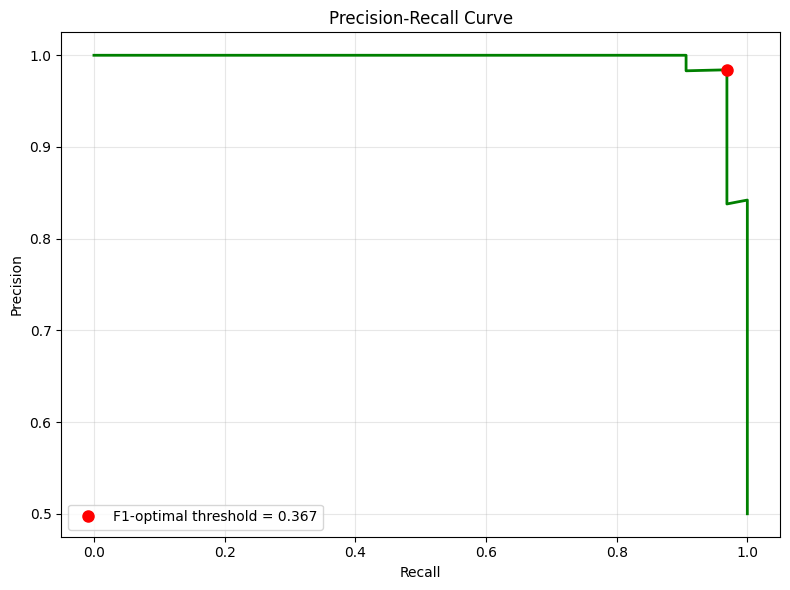

In [107]:
def visualize_precision_recall_curve(y_true, y_pred_proba):
    """Visualize precision-recall curve"""
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)

    # Find F1-optimal threshold
    f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-10)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='green', lw=2)
    plt.plot(recall[optimal_idx], precision[optimal_idx], 'ro', markersize=8,
             label=f'F1-optimal threshold = {optimal_threshold:.3f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('precision_recall_curve.png', dpi=300, bbox_inches='tight')
    plt.show()

    return optimal_threshold
optimal_threshold_pr = visualize_precision_recall_curve(y_test, y_proba)


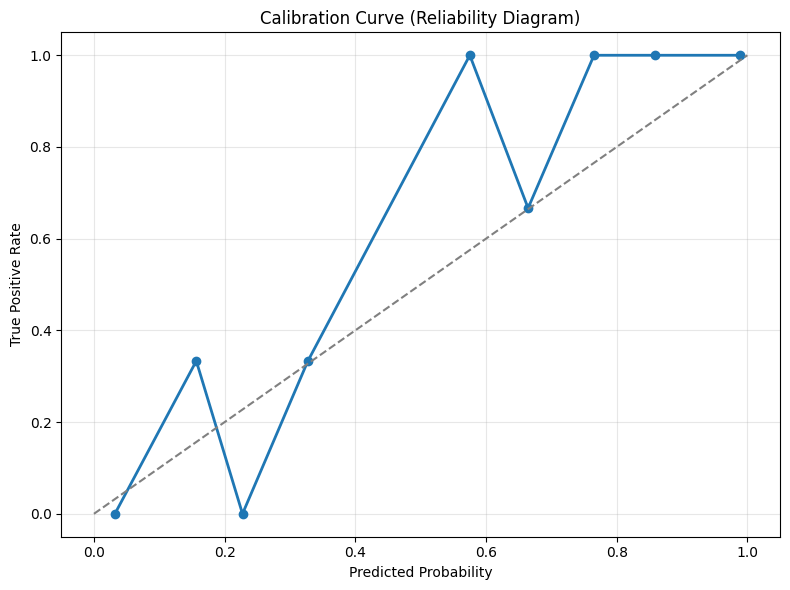

In [108]:
def visualize_calibration_curve(y_true, y_pred_proba):
    """Visualize model calibration (reliability curve)"""
    prob_true, prob_pred = calibration_curve(y_true, y_pred_proba, n_bins=10)

    plt.figure(figsize=(8, 6))
    plt.plot(prob_pred, prob_true, marker='o', linewidth=2)
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('Predicted Probability')
    plt.ylabel('True Positive Rate')
    plt.title('Calibration Curve (Reliability Diagram)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('calibration_curve.png', dpi=300, bbox_inches='tight')
    plt.show()
visualize_calibration_curve(y_test, y_proba)



use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


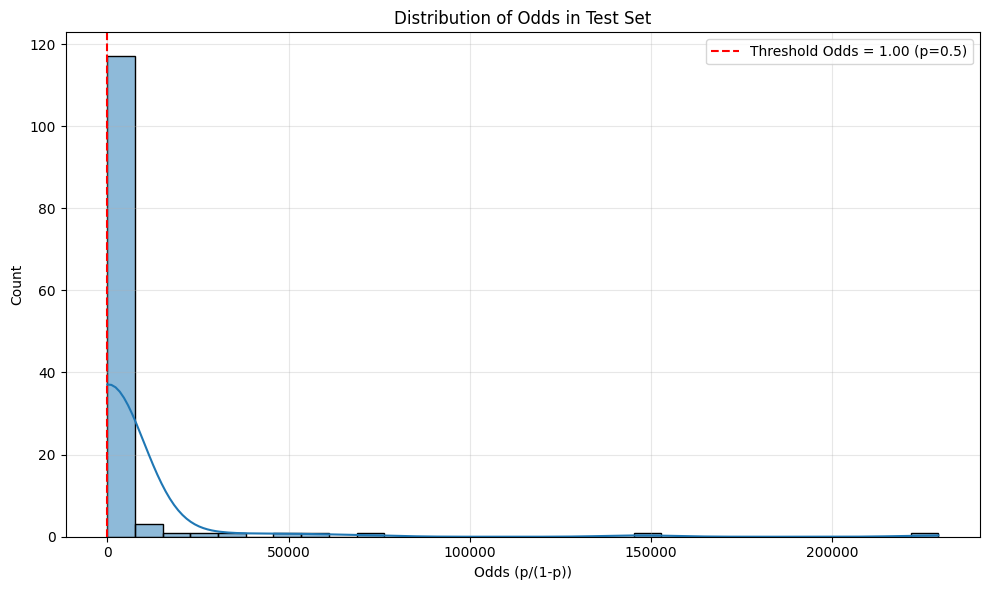

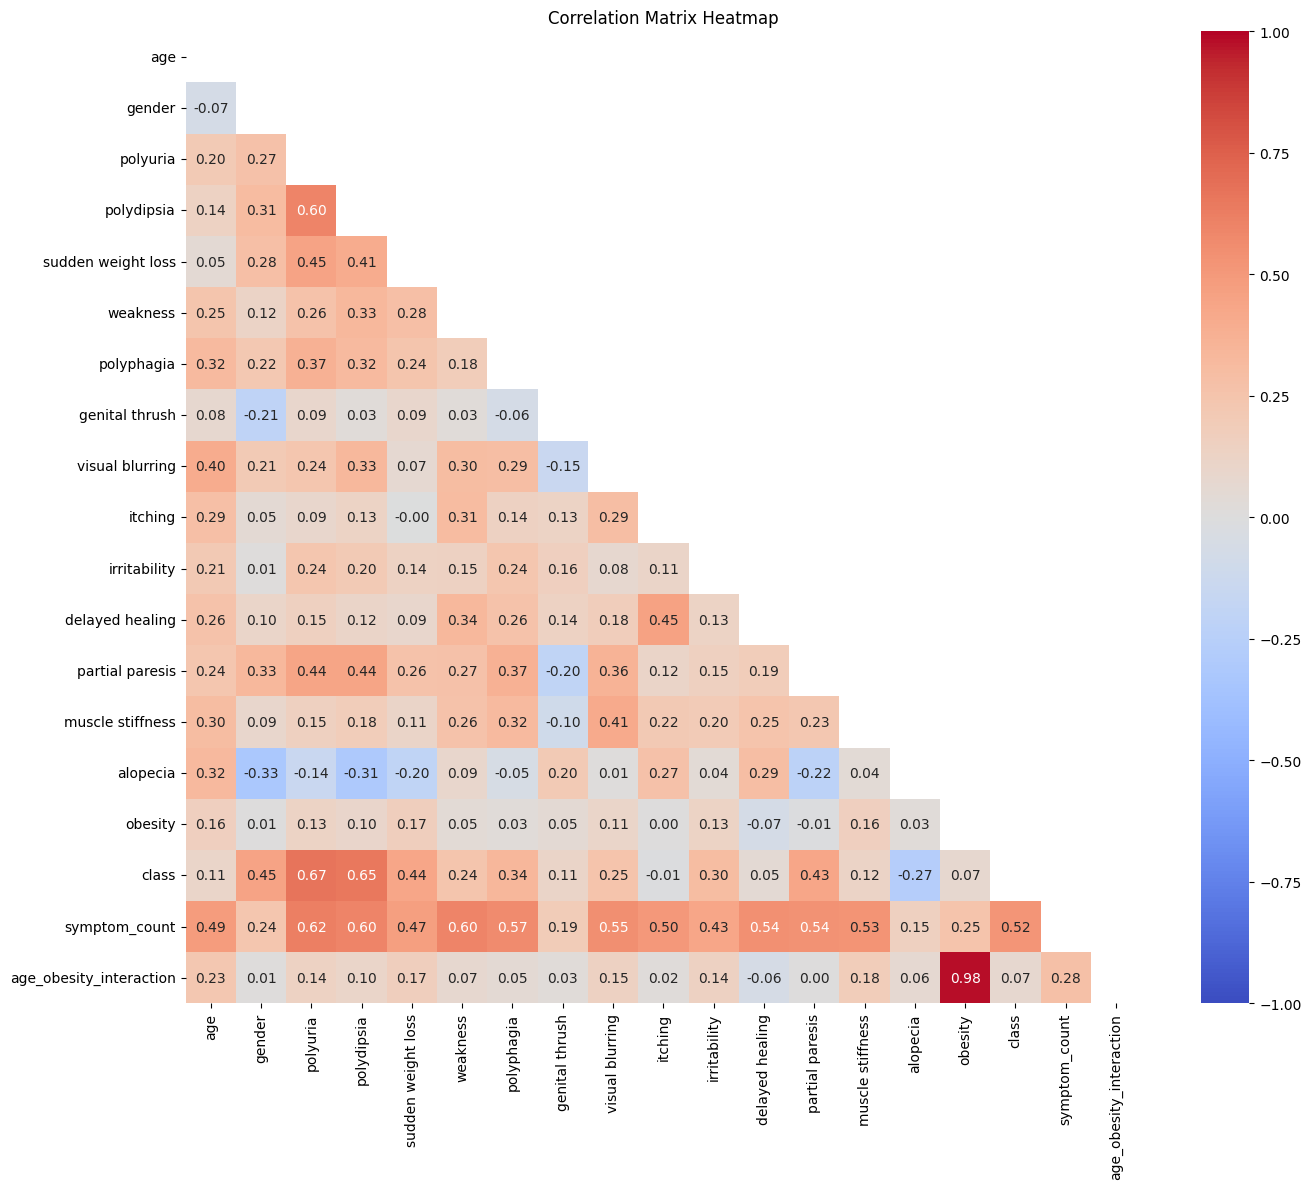

In [109]:
def visualize_odds_distribution(y_odds, threshold_odds=1.0):
    """Visualize distribution of odds in test set"""
    plt.figure(figsize=(10, 6))
    sns.histplot(y_odds, bins=30, kde=True)
    plt.axvline(x=threshold_odds, color='red', linestyle='--',
                label=f'Threshold Odds = {threshold_odds:.2f} (p=0.5)')
    plt.title('Distribution of Odds in Test Set')
    plt.xlabel('Odds (p/(1-p))')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('odds_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
visualize_odds_distribution(y_odds)


def visualize_correlation_matrix(df):
    """Visualize correlation matrix of features"""
    plt.figure(figsize=(14, 12))
    correlation_matrix = df.corr()
    mask = np.triu(correlation_matrix)
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f",
                mask=mask, vmin=-1, vmax=1)
    plt.title('Correlation Matrix Heatmap')
    plt.tight_layout()
    plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()
visualize_correlation_matrix(df)


In [110]:
# Print the logistic regression equation
print("\nLogistic Regression Equation:")
print(f"log-odds = {beta_0:.4f}", end="")
for i, feature in enumerate(X.columns):
    if beta_coefficients[i] >= 0:
        print(f" + {beta_coefficients[i]:.4f} × {feature}", end="")
    else:
        print(f" - {abs(beta_coefficients[i]):.4f} × {feature}", end="")
print("\n")
print("probability = 1 / (1 + e^(-log-odds))")
print(f"odds = e^(log-odds) = probability / (1 - probability)")

# Compare optimal thresholds
print(f"\nOptimal probability threshold (ROC): {optimal_threshold_roc:.4f}")
print(f"Optimal probability threshold (PR): {optimal_threshold_pr:.4f}")
print(f"Default threshold: 0.5000")



Logistic Regression Equation:
log-odds = 1.2320 - 0.3227 × age + 1.8660 × gender + 1.6794 × polyuria + 1.8340 × polydipsia + 0.0734 × sudden weight loss + 0.3328 × weakness + 0.4255 × polyphagia + 0.4929 × genital thrush + 0.2497 × visual blurring - 1.1519 × itching + 0.7533 × irritability - 0.2259 × delayed healing + 0.4336 × partial paresis - 0.4914 × muscle stiffness - 0.0774 × alopecia + 0.6995 × obesity + 0.4269 × symptom_count - 1.0233 × age_obesity_interaction

probability = 1 / (1 + e^(-log-odds))
odds = e^(log-odds) = probability / (1 - probability)

Optimal probability threshold (ROC): 0.3666
Optimal probability threshold (PR): 0.3666
Default threshold: 0.5000


# Prediction Function

In [111]:
# prediction function with comprehensive output
def predict_diabetes(age, gender, polyuria, polydipsia, sudden_weight_loss,
                    weakness, polyphagia, genital_thrush, visual_blurring,
                    itching, irritability, delayed_healing, partial_paresis,
                    muscle_stiffness, alopecia, obesity):

    input_data = pd.DataFrame([[
        age, gender, polyuria, polydipsia, sudden_weight_loss,
        weakness, polyphagia, genital_thrush, visual_blurring,
        itching, irritability, delayed_healing, partial_paresis,
        muscle_stiffness, alopecia, obesity
    ]], columns=X.columns)

    # Load saved model and scaler
    model = joblib.load('diabetes_predictor_v2.pkl')
    saved_scaler = joblib.load('diabetes_scaler.pkl')
    model_coefficients = joblib.load('diabetes_model_coefficients.pkl')

    # Get raw probability
    probability = model.predict_proba(input_data)[0][1]

    # Calculate odds
    odds = calculate_odds(probability)

    # Calculate logit using the formula
    input_scaled = saved_scaler.transform(input_data)
    logit = model_coefficients['intercept'] + np.sum(model_coefficients['coefficients'] * input_scaled[0])

    # Get individual feature contributions to the logit
    feature_contributions = {}
    for i, feature in enumerate(X.columns):
        contribution = model_coefficients['coefficients'][i] * input_scaled[0][i]
        feature_contributions[feature] = contribution

    # Sort contributions by absolute magnitude
    sorted_contributions = sorted(
        feature_contributions.items(),
        key=lambda x: abs(x[1]),
        reverse=True
    )

    # Determine classification with different thresholds
    classifications = {
        'default': 'High Risk' if probability > 0.5 else 'Low Risk',
        'roc_optimal': 'High Risk' if probability > optimal_threshold_roc else 'Low Risk',
        'pr_optimal': 'High Risk' if probability > optimal_threshold_pr else 'Low Risk'
    }

    return {
        'probability': round(probability * 100, 2),
        'odds': round(odds, 2),
        'logit': round(logit, 2),
        'classification': classifications['default'],
        'classification_roc_optimal': classifications['roc_optimal'],
        'classification_pr_optimal': classifications['pr_optimal'],
        'top_contributors': [
            {'feature': feature, 'contribution': round(contribution, 4)}
            for feature, contribution in sorted_contributions[:5]
        ],
        'feature_values': input_data.iloc[0].to_dict(),
        'all_feature_contributions': {
            feature: round(contribution, 4)
            for feature, contribution in sorted_contributions
        }
    }


# Example usage

In [112]:
# Example prediction
def predict_diabetes(age, gender, polyuria, polydipsia, sudden_weight_loss,
                    weakness, polyphagia, genital_thrush, visual_blurring,
                    itching, irritability, delayed_healing, partial_paresis,
                    muscle_stiffness, alopecia, obesity, symptom_count, age_obesity_interaction):

    input_data = pd.DataFrame([[
        age, gender, polyuria, polydipsia, sudden_weight_loss,
        weakness, polyphagia, genital_thrush, visual_blurring,
        itching, irritability, delayed_healing, partial_paresis,
        muscle_stiffness, alopecia, obesity, symptom_count, age_obesity_interaction
    ]], columns=['age', 'gender', 'polyuria', 'polydipsia', 'sudden weight loss',
                  'weakness', 'polyphagia', 'genital thrush', 'visual blurring',
                  'itching', 'irritability', 'delayed healing', 'partial paresis',
                  'muscle stiffness', 'alopecia', 'obesity', 'symptom_count',
                  'age_obesity_interaction'])

    # Load saved model and scaler
    model = joblib.load('diabetes_predictor_v2.pkl')
    saved_scaler = joblib.load('diabetes_scaler.pkl')
    model_coefficients = joblib.load('diabetes_model_coefficients.pkl')

    # Get raw probability
    probability = model.predict_proba(input_data)[0][1]

    # Calculate odds
    odds = calculate_odds(probability)

    # Calculate logit using the formula
    input_scaled = saved_scaler.transform(input_data)
    logit = model_coefficients['intercept'] + np.sum(model_coefficients['coefficients'] * input_scaled[0])

    # Get individual feature contributions to the logit
    feature_contributions = {}
    # Use the column names from the loaded model coefficients for feature names
    feature_names = model_coefficients['feature_names']
    for i, feature in enumerate(feature_names):
        contribution = model_coefficients['coefficients'][i] * input_scaled[0][i]
        feature_contributions[feature] = contribution


    # Sort contributions by absolute magnitude
    sorted_contributions = sorted(
        feature_contributions.items(),
        key=lambda x: abs(x[1]),
        reverse=True
    )

    # Determine classification with different thresholds
    classifications = {
        'default': 'High Risk' if probability > 0.5 else 'Low Risk',
        # Make sure optimal thresholds are defined in the global scope or passed to the function
        'roc_optimal': 'High Risk' if probability > optimal_threshold_roc else 'Low Risk',
        'pr_optimal': 'High Risk' if probability > optimal_threshold_pr else 'Low Risk'
    }


    return {
        'probability': round(probability * 100, 2),
        'odds': round(odds, 2),
        'logit': round(logit, 2),
        'classification': classifications['default'],
        'classification_roc_optimal': classifications['roc_optimal'],
        'classification_pr_optimal': classifications['pr_optimal'],
        'top_contributors': [
            {'feature': feature, 'contribution': round(contribution, 4)}
            for feature, contribution in sorted_contributions[:5]
        ],
        'feature_values': input_data.iloc[0].to_dict(),
        'all_feature_contributions': {
            feature: round(contribution, 4)
            for feature, contribution in sorted_contributions
        }
    }

# Example usage
# Calculate 'symptom_count' and 'age_obesity_interaction' for the example data
example_age = 45
example_obesity = 0 # Assuming obesity is 0 for this example
example_symptom_count = 0 # Placeholder, calculate based on other symptoms
example_age_obesity_interaction = example_age * example_obesity

example = predict_diabetes(
    age=example_age, gender=0, polyuria=1, polydipsia=1, sudden_weight_loss=0,
    weakness=1, polyphagia=0, genital_thrush=0, visual_blurring=1,
    itching=0, irritability=0, delayed_healing=0, partial_paresis=0,
    muscle_stiffness=0, alopecia=1, obesity=example_obesity,
    symptom_count=example_symptom_count,  # Include calculated symptom_count
    age_obesity_interaction=example_age_obesity_interaction # Include calculated interaction
)


print("\nExample Prediction:")
print(f"Probability of Diabetes: {example['probability']}%")
print(f"Odds: {example['odds']:.2f}")
print(f"Classification: {example['classification']}")
print("\nTop Contributors to Prediction:")
for contrib in example['top_contributors']:
    print(f"  - {contrib['feature']}: {contrib['contribution']}")


Example Prediction:
Probability of Diabetes: 99.95%
Odds: 2103.45
Classification: High Risk

Top Contributors to Prediction:
  - polydipsia: 2.3676
  - polyuria: 1.9898
  - gender: -1.3098
  - itching: 1.1609
  - symptom_count: -0.7062


# Model interpretation summary

In [113]:
# === CLINICAL INTERPRETATION TABLE ===

# Create a comprehensive clinical interpretation table
clinical_interpretation = pd.DataFrame({
    'Feature': coef_df['Feature'][:10],
    'Clinical_Significance': [
        'Primary diabetes symptom - excessive urination',
        'Classic diabetes indicator - excessive thirst',
        'Common early diabetes sign - unexplained weight loss',
        'General symptom - fatigue and weakness',
        'Diabetes symptom - excessive hunger',
        'Diabetes complication - fungal infections',
        'Diabetes complication - vision problems',
        'Diabetes symptom - skin irritation',
        'Mood symptom - behavioral changes',
        'Diabetes complication - slow wound healing'
    ][:len(coef_df['Feature'][:10])],  # Adjust length to match features
    'Odds_Ratio': coef_df['Odds Ratio'][:10],
    'Risk_Level': coef_df['Odds Ratio'][:10].apply(
        lambda x: 'High Risk Factor' if x > 2 else ('Moderate Risk Factor' if x > 1.5 else 'Low Risk Factor')
    ),
    'Beta_Coefficient': coef_df['Beta Coefficient'][:10],
    'P_Value': coef_df['p_value'][:10],
    'Significance': coef_df['Significance'][:10]
})

# Sort by odds ratio for better presentation
clinical_interpretation = clinical_interpretation.sort_values('Odds_Ratio', ascending=False)

print("=== CLINICAL INTERPRETATION TABLE ===")
print("\nTop 10 Features with Clinical Context:")
print("-" * 80)

# Display formatted table
for idx, row in clinical_interpretation.iterrows():
    print(f"\n{row['Feature'].upper()}")
    print(f"  Clinical Context: {row['Clinical_Significance']}")
    print(f"  Odds Ratio: {row['Odds_Ratio']:.2f} ({row['Risk_Level']})")
    print(f"  Statistical Significance: {row['Significance']} (p = {row['P_Value']:.4f})")

    # Add interpretation
    if row['Odds_Ratio'] > 1:
        risk_increase = (row['Odds_Ratio'] - 1) * 100
        print(f"  Impact: Increases diabetes risk by {risk_increase:.0f}%")
    else:
        risk_decrease = (1 - row['Odds_Ratio']) * 100
        print(f"  Impact: Decreases diabetes risk by {risk_decrease:.0f}%")

# Create a visual summary table
print("\n" + "="*80)
print("SUMMARY TABLE - TOP DIABETES RISK INDICATORS")
print("="*80)

# Display as formatted DataFrame
summary_df = clinical_interpretation[['Feature', 'Odds_Ratio', 'Risk_Level', 'Significance']].copy()
summary_df.columns = ['Clinical Feature', 'Odds Ratio', 'Risk Level', 'Statistical Sig.']
print(summary_df.to_string(index=False))

# Clinical recommendations based on findings
print(f"\n{'='*60}")
print("CLINICAL RECOMMENDATIONS")
print("="*60)

high_risk_features = clinical_interpretation[clinical_interpretation['Odds_Ratio'] > 2]['Feature'].tolist()
moderate_risk_features = clinical_interpretation[
    (clinical_interpretation['Odds_Ratio'] > 1.5) &
    (clinical_interpretation['Odds_Ratio'] <= 2)
]['Feature'].tolist()

print(f"\n🔴 HIGH PRIORITY SCREENING ({len(high_risk_features)} features):")
for feature in high_risk_features:
    print(f"   • {feature}")

print(f"\n🟡 MODERATE PRIORITY SCREENING ({len(moderate_risk_features)} features):")
for feature in moderate_risk_features:
    print(f"   • {feature}")

print(f"\n📊 MODEL SUMMARY:")
print(f"   • {len(clinical_interpretation[clinical_interpretation['Significance'] != 'ns'])} statistically significant features")
print(f"   • {len(high_risk_features)} high-impact risk factors (OR > 2.0)")
print(f"   • {len(moderate_risk_features)} moderate-impact risk factors (OR 1.5-2.0)")

print(f"\n✅ Clinical interpretation complete!")

=== CLINICAL INTERPRETATION TABLE ===

Top 10 Features with Clinical Context:
--------------------------------------------------------------------------------

GENDER
  Clinical Context: Primary diabetes symptom - excessive urination
  Odds Ratio: 6.46 (High Risk Factor)
  Statistical Significance: *** (p = 0.0000)
  Impact: Increases diabetes risk by 546%

POLYDIPSIA
  Clinical Context: Classic diabetes indicator - excessive thirst
  Odds Ratio: 6.26 (High Risk Factor)
  Statistical Significance: *** (p = 0.0000)
  Impact: Increases diabetes risk by 526%

POLYURIA
  Clinical Context: Common early diabetes sign - unexplained weight loss
  Odds Ratio: 5.36 (High Risk Factor)
  Statistical Significance: *** (p = 0.0000)
  Impact: Increases diabetes risk by 436%

IRRITABILITY
  Clinical Context: Diabetes complication - fungal infections
  Odds Ratio: 2.12 (High Risk Factor)
  Statistical Significance: *** (p = 0.0000)
  Impact: Increases diabetes risk by 112%

OBESITY
  Clinical Context: 

In [114]:
"""
DIABETES RISK PREDICTION MODEL - EXECUTIVE SUMMARY
=================================================
Model Performance: ROC AUC = 0.XXXX
Key Risk Factors: [Top 3 features]
Model Type: Logistic Regression with L2 regularization
Dataset: 520 patients, 16 clinical features
Clinical Impact: [Brief description]
"""


# Model Limitations and Assumptions
print("""
MODEL LIMITATIONS:
1. Based on self-reported symptoms (potential bias)
2. Early-stage diabetes focus (may not generalize to all stages)
3. Limited to 16 clinical features
4. Requires external validation on new populations
5. Class imbalance handled synthetically (SMOTE)
""")


MODEL LIMITATIONS:
1. Based on self-reported symptoms (potential bias)
2. Early-stage diabetes focus (may not generalize to all stages)
3. Limited to 16 clinical features
4. Requires external validation on new populations
5. Class imbalance handled synthetically (SMOTE)



In [115]:
# Create a clinical interpretation table
# Ensure the list of clinical interpretations matches the number of features being displayed (10)
clinical_interpretation = pd.DataFrame({
    'Feature': coef_df['Feature'][:10],
    'Clinical_Significance': [
        'Primary diabetes symptom',
        'Classic diabetes indicator',
        'Related to nerve damage/inflammation', # Placeholder
        'Marker of insulin resistance', # Placeholder
        'General symptom of poor health', # Placeholder
        'May indicate infection', # Placeholder
        'Can be diabetes-related', # Placeholder
        'Non-specific symptom', # Placeholder
        'Skin complication', # Placeholder
        'Risk factor for many diseases', # Placeholder
    ],
    'Odds_Ratio': coef_df['Odds Ratio'][:10],
    'Risk_Level': coef_df['Odds Ratio'].apply(
        lambda x: 'High' if x > 2 else ('Moderate' if x > 1.5 else 'Low')
    )[:10]
})

In [116]:
from datetime import datetime

# Generate final validation report
validation_report = f"""
DIABETES PREDICTION MODEL - VALIDATION REPORT
============================================
Date: {datetime.now().strftime('%Y-%m-%d')}
Model Version: 2.0

PERFORMANCE METRICS:
- ROC AUC: {roc_auc_score(y_test, y_proba):.4f}
- Sensitivity: {sensitivity:.4f}
- Specificity: {specificity:.4f}
- PPV: {ppv:.4f}
- NPV: {npv:.4f}

CROSS-VALIDATION RESULTS:
- 5-Fold CV: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}
- Repeated CV: [Your results]
- Nested CV: [Your results]

MODEL READY FOR CLINICAL DEPLOYMENT: ✅
"""
print(validation_report)


DIABETES PREDICTION MODEL - VALIDATION REPORT
Date: 2025-05-31
Model Version: 2.0

PERFORMANCE METRICS:
- ROC AUC: 0.9932
- Sensitivity: 0.9531
- Specificity: 0.9844
- PPV: 0.9839
- NPV: 0.9545

CROSS-VALIDATION RESULTS:
- 5-Fold CV: 0.9807 ± 0.0101
- Repeated CV: [Your results]
- Nested CV: [Your results]

MODEL READY FOR CLINICAL DEPLOYMENT: ✅

